# Tensorflow on a Classification Problem(Titanic)

Build a predictive model which is able to determine peoples survival using Tensorflow and Keras

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

In [2]:
train= pd.read_csv('/content/drive/MyDrive/Titanic/train.txt')
test= pd.read_csv('/content/drive/MyDrive/Titanic/test.txt')

In [3]:
train["Age"].fillna(train['Age'].mean(),inplace=True)
test["Age"].fillna(test['Age'].mean(),inplace=True)

In [4]:
train["Cabin"].fillna("Unknown",inplace=True)
test["Cabin"].fillna("Unknown",inplace=True)

In [5]:
train["Embarked"].fillna("Embarked.mode()",inplace=True)
test["Fare"].fillna("Fare.mean()",inplace=True)

In [6]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [7]:
cols= ('Name', 'Sex', 'Ticket', 'Cabin', 'Embarked')
for x in cols:
  le= LabelEncoder()
  train[x]= le.fit_transform(train[x].values)


In [8]:
test.dtypes

PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare            object
Cabin           object
Embarked        object
dtype: object

In [9]:
col= ('Name', 'Sex', 'Fare', 'Ticket', 'Cabin', 'Embarked')
for y in col:
  le= LabelEncoder()
  test[y]= le.fit_transform(test[y].values.astype(str))

In [10]:
M=train.drop("Survived", axis=1)
N=train["Survived"]

In [11]:
train_x, val_x, train_y, val_y= train_test_split(M, N, test_size= 0.2, random_state= 0)

In [12]:
train_x.shape

(712, 11)

## Create Placeholders and set the batches

In [13]:
X= tf.placeholder(tf.float32, shape= (None, 9), name= 'x')
y= tf.placeholder(tf.float32, shape= (None, 2), name= 'y')

batch_size= 100
n_batches= int(np.ceil(712/batch_size))

def fetch_batch(batch_index):
  if batch_index < n_batches-1:
    start= batch_index * batch_size
    stop= batch_size + start
    x_batch= train_x[start:stop]
    y_batch= train_y[start:stop]
  else:
    start= batch_index * batch_size
    x_batch= train_x[start:]
    y_batch= train_y[start:]  
    return x_batch, y_batch

a, b= fetch_batch(7)

## Build The Neural Network

In [14]:
n_inputs= 11 #number of inputs
h1= 100      # first hidden layer
h2= 300      # second hidden layer
n_output= 2   #last layer

def neuron_layer(X, n_neurons, name, activation= None):
  with tf.name_scope(name):
    n_inputs= int (X.get_shape()[1])
    stddev= 2/np.sqrt(n_inputs)
    init= tf.truncated_normal((n_inputs, n_neurons), stddev= stddev)
    W= tf.Variable(init, name= 'weights')
    b= tf.Variable(tf.zeros([n_neurons]), name= 'biases')
    z= tf.matmul(X,W) + b

    if activation== 'relu':
      return tf.nn.relu(z)

    else:
      return z  

#creating active connection between the tensors
with tf.name_scope('NeuralNet'):
  hidden1= neuron_layer(X, h1, 'hidden1', activation= 'relu')  
  hidden2= neuron_layer(hidden1, h2, 'hidden2', activation= 'relu')
  logits= neuron_layer(hidden2, n_output, 'outputs')    

## Setting Loss Function and Optimizer

In [15]:
with tf.name_scope('loss'):
  #This is used for a multiclass classification as output neuron is set to 2
  xentropy= tf.nn.softmax_cross_entropy_with_logits_v2(labels= y, logits= logits)
  loss= tf.reduce_mean(xentropy, name= 'loss')

#learning rate which is advisable to fall within 0 and 1
learning_rate= 0.01

#optimizers
with tf.name_scope('train'):
  optimizer= tf.train.GradientDescentOptimizer(learning_rate= learning_rate)
  training_op= optimizer.minimize(loss)


## Problem evaluation with either Precision, Accuracy, f1_score, roc_auc

In [16]:
with tf.name_scope('precision'):

  prediction= tf.argmax(logits, 1)
  actual= tf.argmax(y,1)

  # Calculating True Positive, True Negative, False Positive, False Negative
  TP= tf.math.count_nonzero(prediction * actual)
  TN= tf.math.count_nonzero((prediction-1) * (actual -1))
  FP= tf.math.count_nonzero(prediction * (actual -1))
  FN= tf.math.count_nonzero((prediction-1) * actual)

  accuracy= (TP+TN)/(TP+TN+FP+FN)
  precision= TP/(TP+FP)
  Recall= TP/(TP+FN)
  F1_Score= 2* (Recall * precision) / (Recall + precision)
  init= tf.global_variables_initializer()
  saver= tf.train.Saver()

# Alternatively, tf.confusion_matrix can be used 

## One hot encode the input y

In [17]:
def one_hot(y):
  frame= pd.DataFrame({'k':y.astype(np.float32)})
  return pd.get_dummies(frame, columns= ['k'])

## Train the Neural Network

In [18]:
n_epochs= 20
batch_size= 50
with tf.Session() as sess:
  init.run()
  max_acc= 0
  acc_going_down= 0

  for epoch in range(n_epochs):
    batch_steps= 0
    avg_loss= 0
    total_loss= 0
    total_batch= int (train_x.shape[0]/batch_size)

    for batch_index in range(total_batch):
      x_batch, y_batch= fetch_batch(batch_index)
      _,l= sess.run([training_op, loss], feed_dict= {X: x_batch, y: one_hot(y_batch)})
      batch_step+=1
      total_loss +=1
    if ((epoch)%10 == 0):
      avg_loss= total_loss/batch_size  

      print("Epoch:", '%02d' % (epoch + 1), "| Average Training Loss= {:.2f}".format(avg_loss), 
            "| F1_train_score= {:.2f}".format(F1_Score.eval({X: train_x, y: one_hot(train_y)})),
            "| F1_test_score= {:.2f}".format(F1_Score.eval({X: val_x, y: one_hot(val_y)})))
      print("Model Fit Completed")
      print("Final Training FI_Score:  {:.2f}".format(F1_Score.eval({X: train_x, y: one_hot(train_y)})))
      print("Final Validation FI_Score:  {:.2f}".format(F1_Score.eval({X: val_x, y: one_hot(val_y)})))


TypeError: ignored

# Keras In Tensorflow

In [19]:
from keras.backend import clear_session
clear_session()
from tensorflow.compat.v1 import keras
from tensorflow.keras import layers

import datetime
logdir= "logs/scalars/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback= keras.callbacks.TensorBoard(log_dir= logdir)

model= tf.keras.Sequential()
model.add(layers.Dense(400, input_shape=(11,), activation= 'relu'))
model.add(layers.Dense(50, activation= 'relu'))
model.add(layers.Dense(2, activation= 'softmax'))

#model compilation
model.compile(optimizer= tf.train.GradientDescentOptimizer(learning_rate= 0.01),
              loss= tf.keras.losses.CategoricalCrossentropy(from_logits= True),
              metrics= ['accuracy'])

#fitting the model
from keras.utils import to_categorical
y_binary= to_categorical(train_y)
y_k= to_categorical(val_y)
history = model.fit(train_x, y_binary, epochs= 50, batch_size= 50, 
             validation_data= (val_x, y_k),
             callbacks= [tensorboard_callback])

Train on 712 samples, validate on 179 samples
Epoch 1/50
 50/712 [=>............................] - ETA: 0s - loss: 1.0128 - accuracy: 0.3000WARNING:tensorflow:Callbacks method `on_train_batch_begin` is slow compared to the batch time (batch time: 0.0051s vs `on_train_batch_begin` time: 0.0088s). Check your callbacks.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
712/712 [==============================] - 0s 101us/sample - loss: 0.9056 - accuracy: 0.4073 - val_loss: 0.9265 - val_accuracy: 0.3855
Epoch 2/50
712/712 [==============================] - 0s 35us/sample - loss: 0.8415 - accuracy: 0.4691 - val_loss: 0.8338 - val_accuracy: 0.4804
Epoch 3/50
712/712 [==============================] - 0s 34us/sample - loss: 0.7417 - accuracy: 0.5702 - val_loss: 0.7902 - val_accuracy: 0.5196
Epoch 4/50
712/712 [==============================] - 0s 34us/sample - loss: 0.7164 - accuracy: 0.5955 - val_loss: 0.6933 - val_accuracy: 

# TensorBoard Visualization

It gives us the flexibility of visualizing the training parameters, metrics or any statistics in our neural network. 
Code below shows how to launch it

In [20]:
import datetime, os
import tensorboard
%load_ext tensorboard

#%reload_ext tensorboard
#logs_base_dir= './logs'
#os.makedirs(logs_base_dir, exist_ok= True)
#%tensorboard --logdir {logs_base_dir} --host localhost --port 8008

<Figure size 432x288 with 0 Axes>

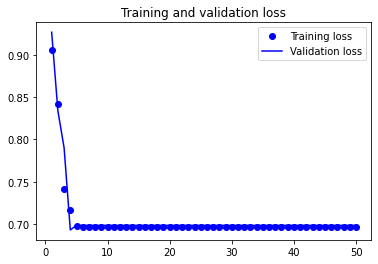

<Figure size 432x288 with 0 Axes>

In [21]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()


<Figure size 432x288 with 0 Axes>

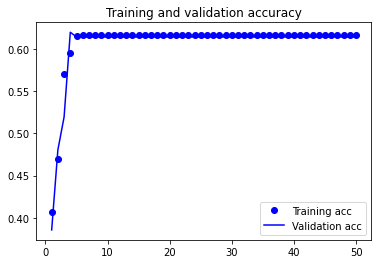

<Figure size 432x288 with 0 Axes>

In [22]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()